In [500]:
from include.Wine_data import *
from include.Fire_data import *
from sklearn.model_selection import StratifiedKFold, learning_curve
from time import perf_counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
def plot_loss_accuracy(history, baseline=None):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    if baseline != None:
        historydf['baseline']=baseline
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(max(0, historydf.values.min()), max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    vloss = history.history['val_loss'][-1]
    vacc = history.history['val_accuracy'][-1]
    plt.title('Loss: %.3f, Acc: %.3f, vLoss: %.3f, vAcc: %.3f' % (loss, acc, vloss, vacc))
    
def train_validate_fold(model, _X_train, _y_train, _X_val, _y_val, epochs=200):
    model.get_weights()
    print("training for ", epochs, "epochs")
    model.fit(_X_train, _y_train, epochs=epochs, verbose = 0)
    scores = model.evaluate(_X_val, _y_val, verbose=0)
    return scores

In [519]:
wine = Wine.load_pickle()
#a summary
print("test data pos percentage", len(wine.y_test[wine.y_test['good']==1]) / len(wine.y_test))
print("size of training", len(wine.X_train))

loading pickle:  ../data/pickles/Wine.pickle
test data pos percentage 0.55625
size of training 1119


In [506]:
class CustomEarlyStopping(Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.best_map10 = 0
        self.best_v_accuracy = 0
    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        v_accuracy = logs.get('val_accuracy')
        map10=logs.get('val_average_precision_at_k10')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.greater(v_accuracy, self.best_v_accuracy):
            self.best_v_loss = v_loss
            self.best_v_accuracy = v_accuracy
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


def nn(X_train, y_train,  X_test, y_test, layers = [16, 8], lr=0.001, batch_size=10, epochs = 100, verbose = 0, validation_split=0.2):
    _model = Sequential()
    _X_train, _X_validation, _y_train, _y_validation = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state = 1)
    for i,l in enumerate(layers):
        if i == 0 : 
            _model.add(Dense(l, activation='relu', input_shape=(_X_train.shape[1],)))
        else:
            _model.add(Dense(l, activation='relu'))
    es = EarlyStopping(monitor='val_accuracy', patience=50)
    t = perf_counter()
    result = {'layers':layers, 'lr':lr, 'batch_size':batch_size}
    _model.add(Dense(1, activation='sigmoid'))
    _model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    result['history'] = _model.fit(_X_train, _y_train, epochs=epochs, verbose=verbose,  batch_size=batch_size, validation_data=(_X_validation, _y_validation) , callbacks=[CustomEarlyStopping(patience=40)])#callbacks = [es])
    result['time'] = perf_counter() - t
    result['it'] = len(result['history'].history['loss'])
    result['val_accuracy'] = result['history'].history['val_accuracy'][-1]
    result['model'] = _model
    return result


def nn_search(X_train, y_train,  X_test, y_test, layers=[[16,8]], lrs=[0.001], batch_sizes=[10], epochs=1000):
    results = []
    for l in layers:
        for lr in lrs:
            for batch_size in batch_sizes:
                results.append(
                    nn(
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        layers = l,
                        lr = lr,
                        batch_size = batch_size,
                        epochs = epochs
                    )
                )
    return results


def nn_experiment(obj = wine, exp = None, layers = None):
    if layers is None:
        layers =[[2,2],[4,4],[8,4],[16,8],[32,16],[64,32],[64,64]]
    _X_train = obj.X_train
    _X_test = obj.X_test
    if exp is not None:
        _X_train = obj.models[exp]['X_train']
        _X_test = obj.models[exp]['X_test']
        
    results = nn_search(
        X_train = _X_train,
        y_train = obj.y_train,
        X_test = _X_test,
        y_test = obj.y_test,
        layers = layers,
        batch_sizes=[None],
        epochs = 500
    )
    for r in results:
        print('result: ', r['val_accuracy'], r['layers'], 'it:', r['it'],'time', r['time'], r['model'].evaluate(_X_test, obj.y_test))
    return results

In [525]:
results_raw = nn_experiment(obj = wine, exp= None)

Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00080: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.5793 - accuracy: 0.7125
result:  0.7276785969734192 [2, 2] it: 157 time 12.284554322017357 [0.579336941242218, 0.7124999761581421]
15/15 [==============================] - 0s 1ms/step - loss: 0.5946 - accuracy: 0.7312
result:  0.71875 [4, 4] it: 80 time 6.133209652034566 [0.5946137309074402, 0.731249988079071]
15/15 [==============================

<Figure size 576x432 with 0 Axes>

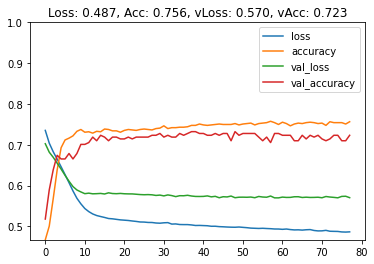

In [508]:
plot_loss_accuracy(results_raw[3]['history'])

In [509]:
results_pca = nn_experiment(obj=wine, exp = 'pca')

Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.6750
result:  0.6830357313156128 [2, 2] it: 64 time 5.044432335998863 [0.6155747771263123, 0.675000011920929]
15/15 [==============================] - 0s 1ms/step - loss: 0.5777 - accuracy: 0.7146
result:  0.6785714030265808 [4, 4] it: 71 time 5.449319771956652 [0.5777307152748108, 0.7145833373069763]
15/15 [====================

<Figure size 576x432 with 0 Axes>

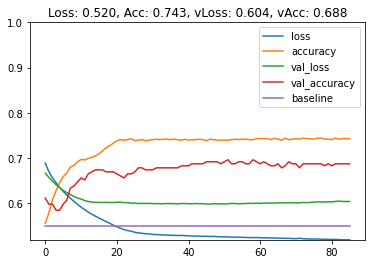

In [510]:
plot_loss_accuracy(results_pca[2]['history'], baseline=0.55)


In [511]:
results_ica = nn_experiment(obj=wine, exp = 'ica')

Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.6500
result:  0.6607142686843872 [2, 2] it: 121 time 9.6374518990051 [0.6131957769393921, 0.6499999761581421]
15/15 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.6438
result:  0.6116071343421936 [4, 4] it: 77 time 6.316668682964519 [0.6557024717330933, 0.643750011920929]
15/15 [=====================

<Figure size 576x432 with 0 Axes>

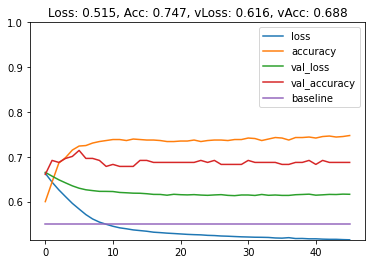

In [512]:
plot_loss_accuracy(results_pca[3]['history'], baseline=0.55)


In [513]:
results_rp = nn_experiment(obj=wine, exp = 'rp')

Restoring model weights from the end of the best epoch.
Epoch 00179: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.6771
result:  0.6607142686843872 [2, 2] it: 179 time 14.757378936978057 [0.6069831848144531, 0.6770833134651184]
15/15 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.6667
result:  0.6428571343421936 [4, 4] it: 73 time 6.310749395983294 [0.5998299717903137, 0.6666666865348816]
15/15 [=================

<Figure size 576x432 with 0 Axes>

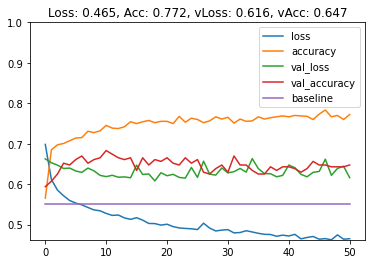

In [514]:
plot_loss_accuracy(results_rp[6]['history'], baseline=0.55)


In [522]:
results_dt = nn_experiment(obj=wine, exp = 'dt')

Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00083: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00143: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
15/15 [==============================] - 0s 2ms/step - loss: 0.5709 - accuracy: 0.7083
result:  0.7142857313156128 [2, 2] it: 153 time 12.770984251052141 [0.5708590149879456, 0.7083333134651184]
15/15 [==============================] - 0s 1ms/step - loss: 0.5462 - accuracy: 0.7188
result:  0.6964285969734192 [4, 4] it: 83 time 6.897985155927017 [0.5462272763252258, 0.71875]
15/15 [============================

<Figure size 576x432 with 0 Axes>

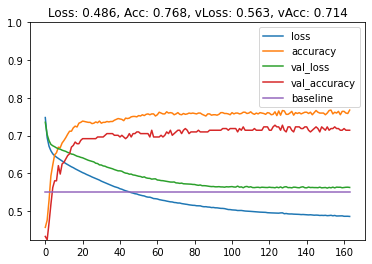

In [518]:
plot_loss_accuracy(results_dt[2]['history'], baseline=0.55)


In [523]:
results_km = nn_experiment(obj=wine, exp = 'km')

Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00138: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.5654 - accuracy: 0.7271
result:  0.7232142686843872 [2, 2] it: 110 time 8.526157453889027 [0.5654303431510925, 0.7270833253860474]
15/15 [==============================] - 0s 1ms/step - loss: 0.5710 - accuracy: 0.7146
result:  0.7232142686843872 [4, 4] it: 138 time 10.415419859113172 [0.570988655090332, 0.7145833373069763]
15/15 [=================

<Figure size 576x432 with 0 Axes>

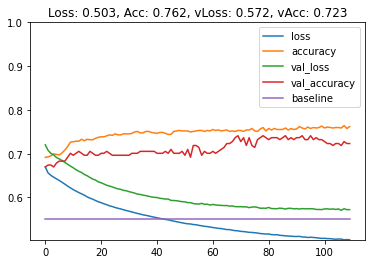

In [524]:
plot_loss_accuracy(results_km[0]['history'], baseline=0.55)


In [526]:
results_em = nn_experiment(obj=wine, exp = 'em')

Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00091: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
15/15 [==============================] - 0s 1ms/step - loss: 0.5688 - accuracy: 0.7188
result:  0.7276785969734192 [2, 2] it: 129 time 9.516309147933498 [0.5688097476959229, 0.71875]
15/15 [==============================] - 0s 2ms/step - loss: 0.5763 - accuracy: 0.7167
result:  0.7142857313156128 [4, 4] it: 74 time 5.590542383957654 [0.576344907283783, 0.7166666388511658]
15/15 [==============================

<Figure size 576x432 with 0 Axes>

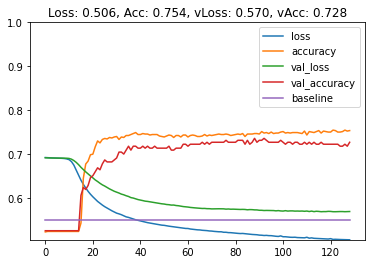

In [527]:
plot_loss_accuracy(results_em[0]['history'], baseline=0.55)


In [517]:
'''
__exp = 'dt'

__X_train, __X_validation, __y_train, __y_validation = train_test_split(wine.models[__exp]['X_train'],wine.y_train,stratify=wine.y_train,test_size=0.2, random_state=42) # before model building
__model = Sequential()
__model.add(Dense(32, activation='relu', input_shape=(__X_train.shape[1],)))
__model.add(Dense(16, activation='relu'))
es = EarlyStopping(monitor='loss', patience=5)
t = perf_counter()
__model.add(Dense(1, activation='sigmoid'))
__model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
__history = __model.fit(__X_train, __y_train, epochs=500, verbose=1,  batch_size=None, validation_data=(__X_validation, __y_validation) , callbacks = [es])
plot_loss_accuracy(__history)
plt.show()
wine.y_train
'''

"\n__exp = 'dt'\n\n__X_train, __X_validation, __y_train, __y_validation = train_test_split(wine.models[__exp]['X_train'],wine.y_train,stratify=wine.y_train,test_size=0.2, random_state=42) # before model building\n__model = Sequential()\n__model.add(Dense(32, activation='relu', input_shape=(__X_train.shape[1],)))\n__model.add(Dense(16, activation='relu'))\nes = EarlyStopping(monitor='loss', patience=5)\nt = perf_counter()\n__model.add(Dense(1, activation='sigmoid'))\n__model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])\n__history = __model.fit(__X_train, __y_train, epochs=500, verbose=1,  batch_size=None, validation_data=(__X_validation, __y_validation) , callbacks = [es])\nplot_loss_accuracy(__history)\nplt.show()\nwine.y_train\n"